# ICAPS24 SkDecide Tutorial: solving PDDL problems with classical planning, and reinforcement learning solvers

In [ ]:
!wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/main/notebooks/install_skdecide.py

from install_skdecide import install_skdecide
install_skdecide(using_nightly_version=True, force_reinstall=False)

In [6]:
# We have dependency problems between ortools installed with scikit-decide and pRDDLGym-jax
# So we uninstall ortools which we don't need in this notebook
!pip uninstall -y ortools
!pip --default-timeout=1000 install rddlrepository pyRDDLGym-jax

Found existing installation: ortools 9.10.4067
Uninstalling ortools-9.10.4067:
  Successfully uninstalled ortools-9.10.4067


![Solver code generator](pictures/skdecide_solver_generator.png)

```python

from typing import *

from skdecide import *
from skdecide.builders.domain import *
from skdecide.builders.solver import *


class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    pass


class MySolver(DeterministicPolicySolver, FromInitialState):
    T_domain = D
    
    def _solve(self, from_memory: Optional[D.T_state] = None) -> None:
        pass
    
    def _get_next_action(self, observation: D.T_observation) -> D.T_event:
        pass
    
    def _is_policy_defined_for(self, observation: D.T_observation) -> bool:
        pass
```

In [6]:
from typing import Any

from skdecide.core import TransitionOutcome, Value, Space
from skdecide.domains import RLDomain
from skdecide.builders.domain import UnrestrictedActions, FullyObservable, Renderable
from skdecide.hub.space.gym import DictSpace, GymSpace, MultiDiscreteSpace
from skdecide.utils import rollout

import pyRDDLGym
from pyRDDLGym.core.simulator import RDDLSimulator
from pyRDDLGym.core.env import RDDLEnv
from pyRDDLGym.core.visualizer.viz import BaseViz
from pyRDDLGym.core.visualizer.chart import ChartVisualizer

from IPython.display import clear_output
%matplotlib notebook

class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    T_state = DictSpace  # Type of states
    T_observation = T_state  # Type of observations
    T_event = MultiDiscreteSpace  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class RDDLDomain(D):

    def __init__(self,
                 rddl_domain: str,
                 rddl_instance: str,
                 backend: RDDLSimulator = RDDLSimulator,
                 base_class: RDDLEnv = RDDLEnv,
                 visualizer: BaseViz = ChartVisualizer,
                 movie_name: str = None,
                 max_frames=100):
        self.rddl_gym_env = pyRDDLGym.make(rddl_domain,
                                           rddl_instance,
                                           backend=backend,
                                           base_class=base_class,
                                           enforce_action_constraints=True)
        self.movie_name = movie_name
        if movie_name is not None:
            self.movie_path = os.path.join('rddl_movies', movie_name)
            if not os.path.exists(self.movie_path):
                os.makedirs(self.movie_path)
            tmp_pngs = os.path.join(self.movie_path, 'tmp_pngs')
            if os.path.exists(tmp_pngs):
                shutil.rmtree(tmp_pngs)
            os.makedirs(tmp_pngs)
            self.movie_gen = MovieGenerator(tmp_pngs, movie_name, max_frames=max_frames)
            self.rddl_gym_env.set_visualizer(visualizer, self.movie_gen)
        else:
            self.movie_gen = None
            self.rddl_gym_env.set_visualizer(visualizer)

    def _state_step(
        self, action: D.T_event
    ) -> TransitionOutcome[D.T_state, Value[D.T_value], D.T_predicate, D.T_info]:
        next_state, reward, terminated, truncated, _ = self.rddl_gym_env.step(action)
        termination = terminated or truncated
        if termination and self.movie_gen is not None:
            self.movie_gen.save_animation(self.movie_name)
            tmp_pngs = os.path.join(self.movie_path, 'tmp_pngs')
            shutil.move(os.path.join(tmp_pngs, self.movie_name + '.gif'),
                        os.path.join(self.movie_path, self.movie_name + '_' +
                                     str(dt.now().strftime("%Y%m%d-%H%M%S")) +
                                     '.gif'))
        return TransitionOutcome(
            state=next_state, value=Value(reward=reward), termination=termination
        )

    def _get_action_space_(self) -> Space[D.T_event]:
        return GymSpace(self.rddl_gym_env.action_space)

    def _state_reset(self) -> D.T_state:
        # SkDecide only needs the state, not the info
        return self.rddl_gym_env.reset()[0]

    def _get_observation_space_(self) -> Space[D.T_observation]:
        return GymSpace(self.rddl_gym_env.observation_space)

    def _render_from(self, memory: D.T_state = None, **kwargs: Any) -> Any:
        # We do not want the image to be displayed in a pygame window, but rather in this notebook
        rddl_gym_img = self.rddl_gym_env.render(to_display=False)
        clear_output(wait=True)
        display(rddl_gym_img)

In [7]:
from typing import Callable, Optional, Dict, Any

from skdecide.solvers import DeterministicPolicySolver
from skdecide.builders.solver import FromInitialState


import pyRDDLGym
from pyRDDLGym.core.policy import BaseAgent, RandomAgent
from pyRDDLGym_jax.core.simulator import JaxRDDLSimulator
from pyRDDLGym_jax.core.planner import JaxBackpropPlanner, JaxOfflineController, JaxOnlineController

class D(RDDLDomain):
    pass

class RDDLSolver(DeterministicPolicySolver, FromInitialState):
    T_domain = D

    def __init__(self,
                 domain_factory: Callable[[], RDDLDomain],
                 controller_cls: BaseAgent = RandomAgent,
                 controller_config: Optional[Dict[str, Any]] = None):
        DeterministicPolicySolver.__init__(self, domain_factory=domain_factory)
        self._domain = domain_factory()
        self.controller_cls = controller_cls
        self.controller = None
        if controller_config is None:
            if controller_cls in [JaxOfflineController, JaxOnlineController]:
                self.controller_config = {
                    'jax_planner_config': {},
                    'jax_controller_config': {}
                }
            else:
                self.controller_config = {}
        else:
            self.controller_config = controller_config

    @classmethod
    def _check_domain_additional(cls, domain: D) -> bool:
        return hasattr(domain, 'rddl_gym_env')
            
    
    def _solve(self, from_memory: Optional[D.T_state] = None) -> None:
        if self.controller_cls is RandomAgent:
            self.controller = RandomAgent(action_space = self._domain.rddl_gym_env.action_space,
                                          num_actions = self._domain.rddl_gym_env.max_allowed_actions)
        else:
            planner = JaxBackpropPlanner(rddl=self._domain.rddl_gym_env.model, **self.controller_config['jax_planner_config'])
            self.controller = JaxOfflineController(planner, **self.controller_config['jax_controller_config'])
    
    def _get_next_action(self, observation: D.T_observation) -> D.T_event:
        return self.controller.sample_action(observation)
    
    def _is_policy_defined_for(self, observation: D.T_observation) -> bool:
        return True

In [8]:
from rddlrepository.core.manager import RDDLRepoManager
from rddlrepository.archive.standalone.Quadcopter.QuadcopterViz import QuadcopterVisualizer
manager = RDDLRepoManager(rebuild=True)
problem_info = manager.get_problem("Quadcopter")
problem_visualizer = QuadcopterVisualizer

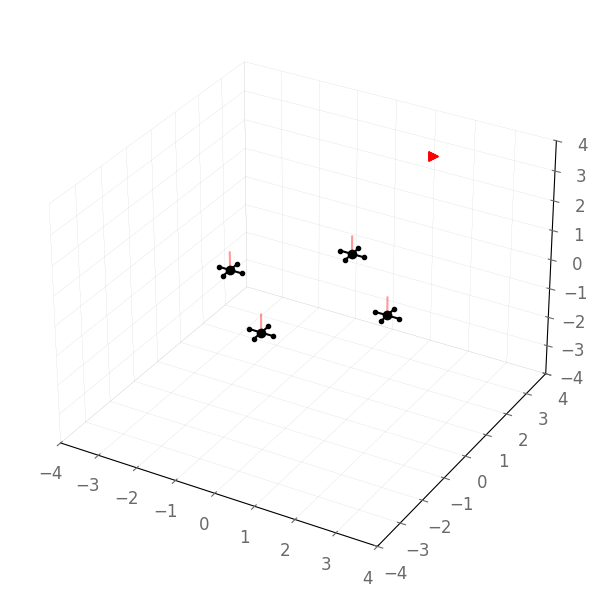

In [9]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger("skdecide.utils").setLevel(logging.INFO)

domain_factory_random_agent = lambda: RDDLDomain(rddl_domain=problem_info.get_domain(),
                                                 rddl_instance=problem_info.get_instance(1),
                                                 visualizer = problem_visualizer)
domain = domain_factory_random_agent()
domain.reset()
domain.render()

In [11]:
from skdecide.utils import rollout

assert RDDLSolver.check_domain(domain_factory_random_agent())

with RDDLSolver(domain_factory=domain_factory_random_agent,
                controller_cls=JaxOnlineController) as solver:
    solver.solve()
    rollout(
        domain_factory_random_agent(),
        solver,
        max_steps=100,
        render=True,
        max_framerate=5,
        verbose=False,
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TypeError: JaxBackpropPlanner.__init__() missing 2 required positional arguments: 'plan' and 'batch_size_train'

In [ ]:
from skdecide.utils import rollout

assert RDDLSolver.check_domain(domain_factory_random_agent())

with RDDLSolver(domain_factory=domain_factory_random_agent,
                controller_cls=RandomAgent) as solver:
    solver.solve()
    rollout(
        domain_factory_random_agent(),
        solver,
        max_steps=100,
        render=True,
        max_framerate=5,
        verbose=False,
    )